# Atmospheric processes: from cloud to global scales
# Exercise on radar, microphysics and mountain meteorology

## Introduction 

In this exercise, you will analyze data from the PLATO campaign that took place at the Davis research station in Antarctica, in January 2019.
The case study corresponds to a precipitation event on January 8, 2019, where interesting signatures were observed in the synoptic flow and precipitation microphysics.

**1st part**\
We will look at data from two radars:
- BASTA is a vertically-pointing W-band (94 GHz) radar, measuring time series of radar reflectivity and mean Doppler velocity
- MXPol is a scanning X-band (9.4 GHz) radar. From its measurements, we extract vertical profiles of radar reflectivity. You will also look at a full Doppler spectrogram, and at some Range-Height Indicator plots (obtained when the radar scans in elevation, at a fixed azimuth angle) to illustrate the scanning capabilities of the instrument, and what information can be inferred from them.

In this first part, we also look at radiosonde data from a sounding launched at Davis station at 12UTC on January 8.

**2nd part**\
To complement the observations, simulations from a high-resolution weather model (Weather and Research Forecast, WRF) are used to study atmospheric dynamics with a 3D perspective. This allows to investigate the interactions between the large-scale synoptic situation, the terrain, and the microphysical processes.


### Before starting the exercise

The following instructions apply if you are running the exercise on the virtual desktop that was provided (VDI). Please refer to the corresponding PDF for instructions on how to install and run the VDI client.

In order to execute the code in this exercise, you will need to activate the `lte` environment (deployed on VDI).
- If you are running the notebook in Visual Studio Code, select this environment in the Kernel manager (icon at the top right of the code window).
- If you are using jupyterlab, make sure you properly activated the environment before launching jupyterlab from the terminal:
    - Open a terminal, type `micromamba activate lte`
    - Then launch jupyterlab by typing `jupyter-lab`

To ensure that your work is properly saved when you logoff your VDI session, make sure that this Exercise notebook is in the `~/Desktop/MyFiles/` directory.

### General instructions
This exercise does not require to code in Python. You will simply have to execute the cells one after the other by pressing Shift + Enter. In some cells, you will have to adjust the values of certain variables, which will be specified clearly (in CAPITAL letters).

The questions will guide you through an interpretation of the radar variables, sounding profiles and model data in terms of cloud or precipitation microphysical properties and atmospheric processes.
More difficult questions are indicated with a star (*).


## Part I

In [1]:
from netCDF4 import Dataset
import numpy as np
import datetime
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':14})
import matplotlib.dates as mdates
import datetime
datefmt = mdates.DateFormatter('%H:%M')
import pandas as pd
plt.rcParams['font.size']=14
import warnings
warnings.filterwarnings('ignore')

In [2]:
# In this cell, we load the radar data
nc_basta = Dataset('Data/BASTA_L2_merged_20190108.nc')
t_basta = nc_basta.variables['time']
dt = [datetime.datetime(2019,1,8)+datetime.timedelta(seconds=int(tt)) for tt in nc_basta.variables['time'][:]]
rg = nc_basta.variables['height'][:]
Ze = nc_basta.variables['reflectivity'][:]
VDop = nc_basta.variables['velocity'][:]
mask = Ze<-50
VDop[mask]=np.nan
Ze[mask]=np.nan

nc_dfr = Dataset('Data/PLATO_dual_frequency_radar_data_20190108.nc')
t_dfr = nc_dfr.variables['time'][:]+3600
dt_dfr = [datetime.datetime.fromtimestamp(tt, tz=datetime.timezone.utc) for tt in t_dfr]
rg_dfr = nc_dfr.variables['range'][:]
DFR = nc_dfr.variables['ZeX'][:]-nc_dfr.variables['ZeW'][:]

In the following cell, we plot the timeseries of radar variables measured by BASTA (radar reflectivity Ze and mean Doppler velocity)

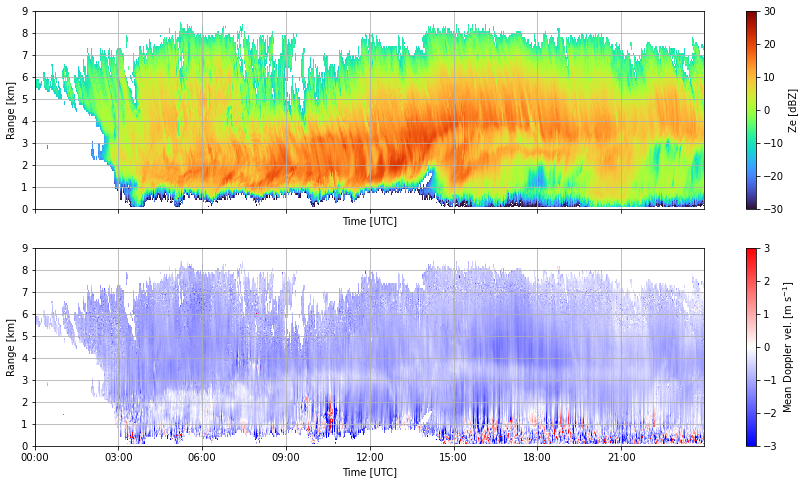

In [3]:
plt.rcParams['font.size']=14
fig,axs = plt.subplots(2,figsize=(15,8),sharex=True)
im0=axs[0].pcolormesh(dt,rg/1e3,Ze,vmin=-30,vmax=30,cmap='turbo')
im1=axs[1].pcolormesh(dt,rg/1e3,VDop,vmin=-3,vmax=3,cmap='bwr')

for ax in axs:
    ax.set_ylim(0,9)
    ax.set_ylabel('Range [km]')
    ax.set_xlabel('Time [UTC]')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.grid()
plt.colorbar(im0,ax=axs[0],label='Ze [dBZ]')
_=plt.colorbar(im1,ax=axs[1],label='Mean Doppler vel. [m s$^{-1}$]')


> **Question 1**: Recall the physical meaning of radar reflectivity (Ze) and mean Doppler velocity (MDV). What are the radar targets here? What information do Ze and MDV respectively convey?

> **Question 2**: When is precipitation observed at the ground? Given the radar data (and the geographical location), what type(s) of precipitation is (are) observed?

> **Question 3**: What type(s) of cloud is (are) present in these timeseries?

> **Question 4**: What do you observe in the radar timeseries at low levels (below ~1km, especially before 15UTC)? What microphysical process(es) is(are) happening?


In the next cell, we plot the standard variables measured by the radiosonde launched at Davis station on January 8 at 12UTC. 


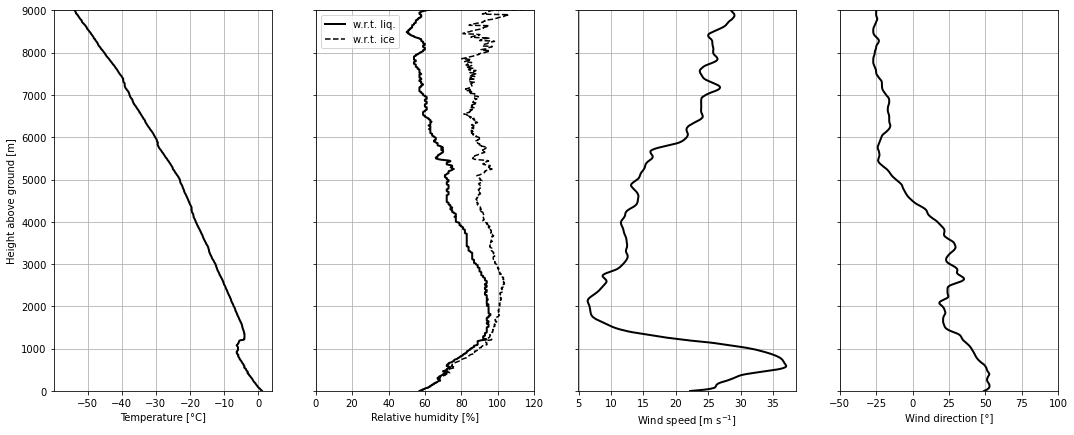

In [4]:
# In this cell, we load the radiosounding data
headers = ['Altitude A.G.L (m)', 'Pressure (Pa)', 'Temperature (K)', 'Specific humidity (kg/kg)', 'RH w.r.t liq (%)', 'RH w.r.t ice (%)', 'Wind speed (m/s)', 'Wind direction (deg)']
RS = pd.read_csv('Data/Davis_RS_20190108_12.txt',sep='\t',names = headers )
wind_dir = RS['Wind direction (deg)']
wind_dir[wind_dir>300]=wind_dir-360

fig,axs=plt.subplots(1,4,figsize=(18,7),sharey=True)
axs[0].plot(RS['Temperature (K)']-273.15, RS['Altitude A.G.L (m)'],'k',lw=2)
axs[1].plot(RS['RH w.r.t liq (%)'], RS['Altitude A.G.L (m)'],'k',lw=2, label='w.r.t. liq.')
axs[1].plot(RS['RH w.r.t ice (%)'], RS['Altitude A.G.L (m)'],'--k',lw=1.5, label='w.r.t. ice')
axs[2].plot(RS['Wind speed (m/s)'], RS['Altitude A.G.L (m)'],'-k',lw=2)
axs[3].plot(RS['Wind direction (deg)'], RS['Altitude A.G.L (m)'],'-k',lw=2)
axs[0].set_ylim(0,9000)
axs[1].set_xlim(0,120)
axs[3].set_xlim(-50,100)
axs[0].set_ylabel('Height above ground [m]')
axs[0].set_xlabel('Temperature [°C]')
axs[1].set_xlabel('Relative humidity [%]')
axs[1].legend()
axs[2].set_xlabel('Wind speed [m s$^{-1}$]')
axs[3].set_xlabel('Wind direction [°]')
for ax in axs:
    ax.grid()


> **Question 5** How do these sounding data confirm (or not) your answer to question 4?


We now plot the dual-frequency ratio between X and W-band reflectivity, which is defined as $DFR = Ze_X - Ze_W$ with $Ze_X$ and $Ze_W$ in logarithmic units (dBZ).


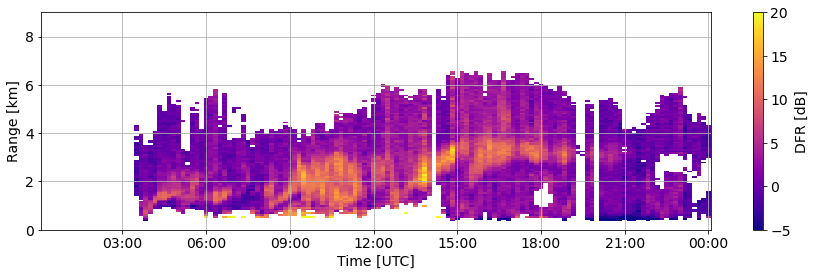

In [5]:
plt.rcParams['font.size']=14
fig,ax = plt.subplots(figsize=(15,4))
im0=ax.pcolormesh(dt_dfr,rg_dfr/1e3,DFR.T,vmin=-5,vmax=20,cmap='plasma')
ax.set_ylim(0,9)
ax.set_ylabel('Range [km]')
ax.set_xlabel('Time [UTC]')
ax.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
_=plt.colorbar(im0,label='DFR [dB]')


>**Question 6** Recall how DFR can be interpreted in terms of precipitation microphysics. What possible processes could explain the regions of higher DFR in this timeseries?


To investigate this further, in the following cells we plot additional radar variables. 
- The full radar Doppler spectrogram measured at 09:50UTC.
- A Range-Height indicator (RHI) plots for two variables; these plots are obtained when the radar scans in elevation (at a fixed azimuth). 

In the next cell, we load the data and print the list of polarimetric radar variables available for the RHI.
 

In [6]:
# Load the Doppler spectrogram
nc_spec = Dataset('Data/spec_XPOL_20190108_095053.nc', 'r')
rg_spec = nc_spec['range'][:]
vel_spec = nc_spec['velocity'][:]
spec = nc_spec['spectrum'][:]

# Load the RHI
import pyart
radar = pyart.io.read_cfradial('Data/MXPol-cfradial-20190108-092747-RHI-101_0.nc')
display = pyart.graph.RadarDisplay(radar)

# We mask out noisy regions, identified through the Rhohv variable
mask = radar.fields['Rhohv']['data']<=0.6
for key in radar.fields.keys():
    radar.fields[key]['data'][mask] = np.nan

# We mask out high-elevation regions for the dual-polarization variables (at high elevation their values are not meaningful)
mask_el = (radar.elevation['data'] > 45) & (radar.elevation['data'] < 135)
for key in ['Zdr', 'Kdp', 'Phidp', 'Rhohv']:
    radar.fields[key]['data'][mask_el,:] = np.nan
print('List of available polarimetric radar variables in the RHI: \n')
for k in radar.fields.keys():
    print(k, ': ', radar.fields[k]['long_name'], ' [', radar.fields[k]['units'], ']')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/billault/code/anaconda3/envs/acbr/lib/python3.9/site-packages/mpl_toolkits/basemap/__init__.py:33: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _matplotlib_version = LooseVersion(_matplotlib_version)
/home/billault/code/anaconda3/envs/acbr/lib/python3.9/site-packages/mpl_toolkits/basemap/__init__.py:34: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _mpl_required_version = LooseVersion('0.98')


List of available polarimetric radar variables in the RHI: 

Zh :  Reflectivity  [ dBZ ]
Zdr :  Diff. reflectivity  [ dB ]
Kdp :  Specific differential phase (KDP)  [ degrees/km ]
Phidp :  Differential phase (PhiDP)  [ degrees ]
Rhohv :  Copolar corr. coeff  [ - ]
RVel :  Mean doppler velocity  [ m/s ]
Sw :  Spectral Width  [ m/s ]
SNRh :  SNR at hor. pol.  [ - ]
SNRv :  SNR at vert. pol.  [ - ]
Psidp :  Total diff. phase  [ deg ]
Signal_h :  Signal at hor. pol.  [ mW ]
Signal_v :  Signal at vert. pol.  [ mW ]


> **Question 7** What are the most relevant radar variables in the RHI that can confirm the hypothesis from Question 6?

In the first lines of the next cell, set `VAR_1` and `VAR_2` to the names of these variables (following the abbreviated names in the list above, i.e., 'Zh', 'Zdr', 'Kdp', 'Phidp', etc.). Adjust the min and max values of the colorbar with the corresponding variables (`VMIN_VAR_1`, etc.) to obtain a nice-looking result for the RHI plots in the right panels.

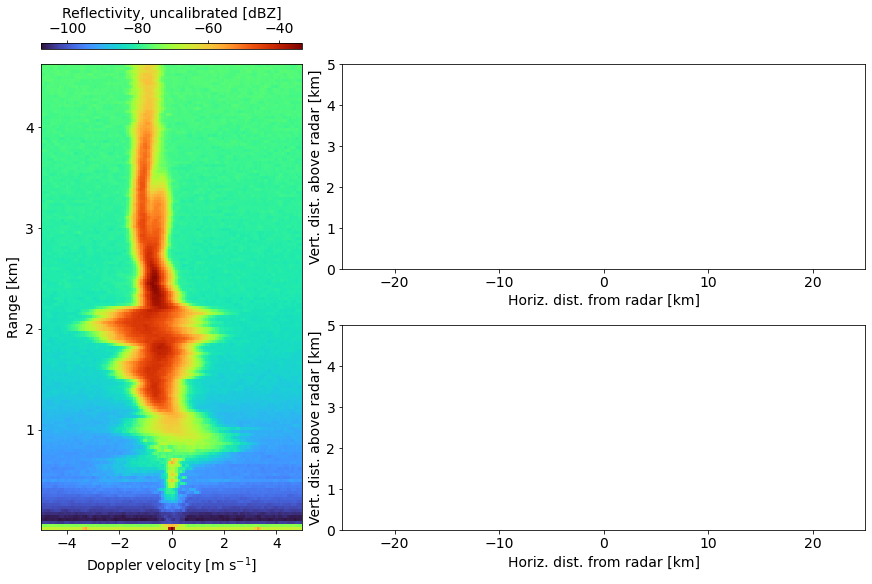

In [7]:
VAR_1 = None # Replace with variable name
VMIN_VAR_1 = -999
VMAX_VAR_1 = 999

VAR_2 = None # Replace with variable name
VMIN_VAR_2 = -999
VMAX_VAR_2 = 999

#############################################333333


fig, axs = plt.subplot_mosaic(
    [["spec", "RHI1", "RHI1"],
     ["spec", "RHI2", "RHI2"]], constrained_layout=True,
     figsize=(12,8)
)

spec_plot=axs["spec"].pcolormesh(vel_spec, rg_spec, spec, cmap='turbo')
plt.colorbar(spec_plot, ax=axs["spec"],aspect=40,label='Reflectivity, uncalibrated [dBZ]', orientation='horizontal', location='top', pad=.02)

if not (VAR_1 is None):
    display.plot_rhi(VAR_1,ax=axs['RHI1'], vmin=VMIN_VAR_1, vmax=VMAX_VAR_1, title='')
if not (VAR_2 is None):
    display.plot_rhi(VAR_2,ax=axs['RHI2'], vmin=VMIN_VAR_2, vmax=VMAX_VAR_2, title='')

axs["spec"].set_xlim(-5,5)
axs["spec"].set_xlabel('Doppler velocity [m s$^{-1}$]')
axs["spec"].set_ylabel('Range [km]')
for key in ['RHI1', 'RHI2']:
    axs[key].set_xlim(-25,25)
    axs[key].set_ylim(0,5)
    axs[key].set_xlabel('Horiz. dist. from radar [km]')
    axs[key].set_ylabel('Vert. dist. above radar [km]')
# fig.tight_layout()

> **Question 8** What do you observe in the RHIs around the same altitude range as the high DFR region, and what do you infer?

> **Question 8bis (*)** Describe the signatures observed at different altitudes in the Doppler spectrogram, and propose explanations for the corresponding processes, from top to bottom.


## Part II

We propose the hypothesis that interaction between the large-scale atmospheric flow and the local orographic terrain is responsible for the observed phenomena:
- the low-level process discussed in questions 4-5, 
- and the higher-level process observed in question 6. 

The next steps of the exercise investigate this hypothesis, by relying on the outputs of a high-resolution numerical model (Weather Research Forecast, WRF) which was run on this event.

This corresponds to the file `wrfout_Davis1_v2lessdiff_d03_subselection.nc` inside the Exercise_2/Data/ folder.

Two time steps are available in the data file: 8 January 2019 at 09:00UTC (`TIME_IDX = 0`), and 10 January 2019 at 12:00UTC (`TIME_IDX = 1`). For the main part of the analysis, we use the first time step.

In [8]:
%reset -f

# Import required libraries
import wrf
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import datetime
import matplotlib.colors as colors

# Load and prepare data
nc = Dataset('Data/wrfout_Davis1_v2lessdiff_d03_subselection.nc')
TIME_IDX = 0
lat_Davis, lon_Davis = -68.576667, 77.9675
pivot_point = wrf.CoordPair(lat=lat_Davis, lon=lon_Davis)

# Load the atmsopheric variables
it = TIME_IDX
pressure = wrf.getvar(nc, "pressure",timeidx=it)
wa = wrf.getvar(nc,"wa",units="m s-1",timeidx=it)
ua = wrf.getvar(nc,"ua",units="kt",timeidx=it)
va = wrf.getvar(nc,"va",units="kt",timeidx=it)
h = wrf.getvar(nc,"height_agl",timeidx=it)+wrf.getvar(nc,"ter",timeidx=it)
ter = wrf.getvar(nc,"ter",timeidx=it)
th = wrf.getvar(nc,"th",units="K",timeidx=it)
rh_lw = wrf.getvar(nc,"rh",timeidx=it)
temp = wrf.getvar(nc,"temp",units="K",timeidx=it)
pcum = wrf.getvar(nc, "RAINNC",timeidx=-1)
dt_wrf = [datetime.datetime(2019,1,7,0,tzinfo=datetime.timezone.utc)+datetime.timedelta(minutes=int(m)) for m in nc['XTIME'][:]]

# A few calculations to derive relative humidity w.r.t ice 
A_w = 2.53 * (10**8) #kPa
B_w = 5.42 * (10**3) # K
es_w = A_w * np.exp(-((B_w)/temp))
A_i = 3.41 * (10**9) #kPa
B_i = 6.13 * (10**3) #K
es_i=A_i* np.exp(-((B_i)/temp))
rh_i=rh_lw*(es_w/es_i)

In the next cell, you will plot a map of certain meteorological fields in the area of the research station, as modeled with WRF.
At the beginning of the cell, you can define whether or not to plot certain fields, and at which altitude: you can choose to plot them at ground level (set `ALTITUDE` to -1) or at a given fixed altitude (i.e., horizontal cross-section of the domain.)


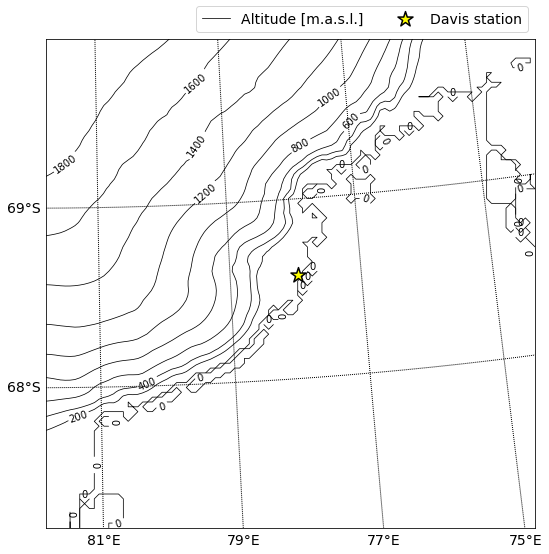

In [9]:
# 1 - Define whether to display horizontal wind field and how
# Wind barbs are a concise way of representing the horizontal wind field with speed and direction. They follow a specific convention (detailed here for instance: https://www.weather.gov/hfo/windbarbinfo)
WIND_BARBS = False # Set to True to plot the wind barbs
WIND_BARBS_ALTITUDE = -1 # Set to -1 if you want to plot the wind field at the surface; set to an altitude value > 0 to plot the wind field at this altitude.

# 2 - Define whether to display vertical wind field and how
W_WIND_CONTOURS = False # Set to True to plot the vertical wind field
W_WIND_ALTITUDE = -1 # Set to -1 if you want to plot the wind field at the surface; set to an altitude value > 0 to plot the wind field at this altitude.

# 3 - In the next cell we propose to plot a **vertical** cross-section of meteorological fields. Here you can define the direction of the cross-section (passing through Davis research station) by setting the ANGLE value.
PLOT_CROSS_SECT_LINE = False
ANGLE = 0

# 4 - Define whether to display the cumulated precipitation (for question 13).
PCUM_CONTOURS = False

###############################################################################

# Get the lat/lon coordinates
lats, lons = wrf.latlon_coords(h)
# Get the basemap object
bm = wrf.get_basemap(ter,resolution='i')
x, y = bm(wrf.to_np(lons), wrf.to_np(lats)) # Convert the lat/lon coordinates to x/y coordinates in the projection space

# Create the figure
fig = plt.figure(figsize=(12,9))
ax = plt.axes()

# Add the terrain contours
levels = np.arange(0,2000,200)
contours = bm.contour(x, y, wrf.to_np(ter), levels=levels, colors="black",linewidths=.75)
plt.clabel(contours, inline=1, fontsize=10, fmt="%i")
ax.plot([-1,-1],[-1,-1], lw = .75, label='Altitude [m.a.s.l.]',color='black')

# Add the geographic boundaries
bm.drawcoastlines(linewidth=1.5)
bm.drawstates(linewidth=0.25)
bm.drawcountries(linewidth=0.25)
bm.drawparallels(np.arange(-70., -67., 1.), labels=[1,0,0,0])
bm.drawmeridians(np.arange(75.,82.,2.), labels=[0,0,0,1])

# Add Davis station location 
xd,yd = bm(lon_Davis,lat_Davis)
bm.scatter(xd,yd,marker='*',color='yellow',edgecolor='k',s=250,zorder=100,linewidth=1.5, label = 'Davis station')
ncols = 2

# Add the wind barbs
if WIND_BARBS:

    if WIND_BARBS_ALTITUDE > 0:
        u_barbs = wrf.interplevel(ua, h, WIND_BARBS_ALTITUDE)
        v_barbs = wrf.interplevel(va, h, WIND_BARBS_ALTITUDE)
    else: # wind field at the surface
        u_barbs = ua[0]
        v_barbs = va[0]

    bm.barbs(x[::10,::10], y[::10,::10], wrf.to_np(u_barbs[::10, ::10]), wrf.to_np(v_barbs[::10, ::10]), length=6, zorder=10)


# Add the wind speed contours
if W_WIND_CONTOURS:
    if W_WIND_ALTITUDE > 0:
        w_field = wrf.interplevel(wa, h, W_WIND_ALTITUDE)
    else:
        w_field = wa[0]

    w_levels = np.linspace(-1.5,1.5,100,endpoint=True)
    wspd_contours = bm.contourf(x, y, wrf.to_np(w_field), w_levels, cmap="seismic",extend="both")
    cbar_ticks = np.linspace(-1.5,1.5,7, endpoint=True)
    cbar = plt.colorbar(wspd_contours, ax=ax, fraction=0.046, pad=0.04, label = 'Vertical wind [m s$^{-1}$]')
    cbar.set_ticks(cbar_ticks)


if PCUM_CONTOURS:
    pcum_levels = np.arange(0,50,1)#,endpoint=True)
    pcum_contours = bm.contourf(x, y, wrf.to_np(pcum), pcum_levels, cmap='Blues',extend="max")
    cbar = plt.colorbar(pcum_contours, ax=ax, fraction=0.046, pad=0.04, label = 'Cumulated precip. [mm]')


# Add the direction of the vertical cross-section
if PLOT_CROSS_SECT_LINE:
    ter_line = wrf.interpline(ter, wrfin=nc, pivot_point=pivot_point, angle=ANGLE,latlon = True, meta=True)
    coord_pairs = wrf.to_np(ter_line.coords["xy_loc"])
    latline = [cc.lat for cc in coord_pairs]
    lonline = [cc.lon for cc in coord_pairs]
    xline,yline = bm(lonline,latline)
    bm.plot(xline,yline,'-',color='fuchsia',lw=2.5, label='cross-section')
    ncols +=2

ax.legend(bbox_to_anchor=(1,1), loc='lower right',ncol=ncols)



>**Question 9** Look at the map with no meteorological fields plotted (only terrain contours). Briefly describe the topography.

>**Question 10** Plot the horizontal wind field (wind barbs) at a chosen altitude (surface level or horizontal cross-section - you can try several). Discuss its orientation with respect to the topography, in the vicinity of the station. Give examples of what could result from this interaction between synoptic/mesoscale flow and orogaphy.

>**Question 11** Plot the vertical wind field at a chosen altitude (surface level or horizontal cross-section - you can try several). Discuss, and propose explanations (taking into account the previous question).


We will now investigate this further to see how these observations relate to the observed radar signatures and microphysical processes.
For this, we look at a vertical cross section through the domain, passing at the research station.\
In the **previous** cell, choose a good angle for the cross-section direction and visualize it.

In the next cell, you can activate certain variables to plot in this cross-section (set their value to ``True``).

>**Question 12** Plot the wind field cross-section (wind barbs and vertical wind) and describe the pattern that you see. How does the topography influence the wind field? (relate to the previous questions)

Text(0, 0.5, '[mm]')

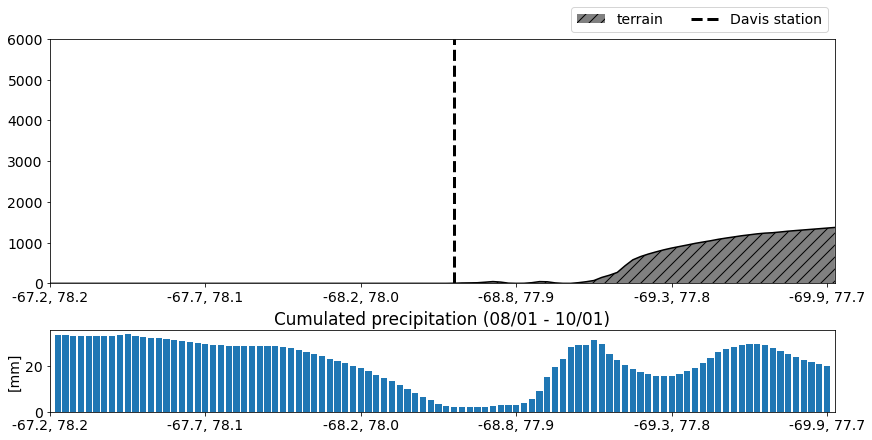

In [10]:
WIND_BARBS = False
W_WIND = False # Vertical wind
POTENTIAL_TEMPERATURE = False
RH_I = False # Relative humidity with respect to ice
TURB_DISS = False

###########################################################

wspd_cross = wrf.vertcross(wa, h, wrfin=nc, pivot_point=pivot_point, angle = ANGLE, latlon=True, meta=True)
v_cross = wrf.vertcross(va, h, wrfin=nc, pivot_point=pivot_point, angle=ANGLE, latlon=True, meta=True)
u_cross = wrf.vertcross(ua, h, wrfin=nc, pivot_point=pivot_point, angle=ANGLE, latlon=True, meta=True)
th_cross = wrf.vertcross(th, h, wrfin=nc, pivot_point=pivot_point, angle=ANGLE, latlon=True, meta=True)
rhi_cross = wrf.vertcross(rh_i, h, wrfin=nc, pivot_point=pivot_point, angle=ANGLE, latlon=True, meta=True)
ter_line = wrf.interpline(ter, wrfin=nc, pivot_point=pivot_point, angle=ANGLE,latlon = True, meta=True)
pcum_line = wrf.interpline(pcum, wrfin=nc, pivot_point=pivot_point, angle=ANGLE,latlon=True, meta=True)
cldfra = wrf.getvar(nc,'CLDFRA',timeidx=0)
cldfra_cross = wrf.vertcross(cldfra, h, wrfin=nc, pivot_point=pivot_point, angle = ANGLE, latlon=True, meta=True)
qdiss = wrf.getvar(nc, 'QDISS')[:-1]
qdiss_cross = wrf.vertcross(qdiss, h, wrfin=nc, pivot_point=pivot_point, angle = ANGLE, latlon=True, meta=True)

xs = np.arange(0, wspd_cross.shape[-1], 1)
ys = wrf.to_np(wspd_cross.coords["vertical"])
coord_pairs = wrf.to_np(ter_line.coords["xy_loc"])

lats_arr = np.array([xy.lat for xy in coord_pairs])
lons_arr = np.array([xy.lon for xy in coord_pairs])
i_Davis = np.argmin((lats_arr-lat_Davis)**2+(lons_arr-lon_Davis)**2)

# Create the figure
fig,(ax,ax1) = plt.subplots(2,figsize=(12,6),gridspec_kw={'height_ratios':[3,1]},sharex=False,constrained_layout=True)
ncol=2

# Plot the terrain profile
ht_fill = ax.fill_between(xs, 0, wrf.to_np(ter_line), facecolor="gray",hatch='//', label='terrain')
ax.plot(xs,ter_line,'k')
ax.plot()
ax.vlines(i_Davis,0,6000,'k',linestyle='--',lw=3, label='Davis station')

# Define the x-axis
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = ['%.1f, %.1f'%(pair.lat,pair.lon) for pair in coord_pairs]
num_ticks = 5
thin = int((len(x_ticks) / num_ticks) + .5)
ax.set_xticks(x_ticks[::thin])
ax.set_xticklabels(x_labels[::thin])
ax1.set_xticks(x_ticks[::thin])
ax1.set_xticklabels(x_labels[::thin])
ax.set_xlim(x_ticks[0], x_ticks[-1])
ax1.set_xlim(x_ticks[0], x_ticks[-1])

# Add the wind barbs
if WIND_BARBS:
    x_barb=10
    y_barb=5
    ax.barbs(xs[::x_barb],ys[::y_barb],u_cross[::y_barb,::x_barb],v_cross[::y_barb,::x_barb],zorder=10,length=6,linewidth=.75)

# Make the filled contour plot of vertical wind
if W_WIND:
    wspd_contours = ax.contourf(xs,ys,wrf.to_np(wspd_cross), cmap="seismic",levels=np.linspace(-1.5,1.5,50,endpoint=True),extend='both')
    cbar_ticks = np.linspace(-1.5,1.5,7, endpoint=True)
    cbar = plt.colorbar(wspd_contours, ax=ax, fraction=0.046, pad=0.04, label = 'vertical wind [m s$^{-1}$]')
    cbar.set_ticks(cbar_ticks)


# Contour plot of potential temperature
if POTENTIAL_TEMPERATURE:
    th_contours = ax.contour(xs,ys,wrf.to_np(th_cross), colors='k',levels=np.arange(200,350,2))
    plt.clabel(th_contours, th_contours.levels[::2], inline=1, fontsize=10, fmt="%iK")
    ax.plot([-1,-1],[-1,-1], label='Pot. temp.',color='k')
    ncol+=1

def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"

if RH_I:
    rhi_contours = ax.contour(xs,ys,wrf.to_np(rhi_cross), colors='g',levels=np.arange(30,120,5))
    plt.clabel(rhi_contours, rhi_contours.levels[::2], inline=1, fontsize=10, fmt=fmt)
    ax.plot([-1,-1],[-1,-1], label='RH w.r.t.  ice',color='g')
    ncol+=1


if TURB_DISS:
    qdiss_contours = ax.contour(xs,ys,wrf.to_np(qdiss_cross), colors='magenta',levels=np.logspace(-5,2,14,endpoint=True),extend='both',norm=colors.LogNorm())
    plt.clabel(qdiss_contours, qdiss_contours.levels[::2], inline=1, fontsize=10, fmt="%.0E")
    ax.plot([-1,-1],[-1,-1], label='turb. diss.',color='magenta')
    ncol+=1

ax.legend(bbox_to_anchor=(1,1), loc='lower right',ncol=ncol)

ax.set_ylim(0,6000)
ax1.bar(xs,pcum_line)
ax1.set_title('Cumulated precipitation (08/01 - 10/01)')
ax1.set_ylabel('[mm]')


We now examine other meteorological variables. \
In the previous cell, the *bottom* plot displays the cumulated precipitation (at ground level) along the cross-section line, during the entire event.

>**Question 13** Based on this plot, how does the precipitation pattern seem correlated with the topography? Going back to the cell above, plot the *map* of cumulated precipitation to confirm this.

>**Question 14** Include the relative humidity contours in the cross-section plots. Describe and discuss; how is this consistent with the wind field, the precipitation pattern, and with the results from the first part of the exercise (radar + radiosounding, questions 4 and 5)?  What phenomenon could this correspond to? 

>**Question 14bis** Include the potential temperature contours in the cross-section plots. Describe and discuss; what does it reveal about the cause of the phenomenon?

Note: feel free to remove the previously drawn contours if the figures becomes too difficult to read (set the corresponding variables back to ``False``).

>**Question 15** Include the "TURB_DISS" field (dissipation rate of turbulent kinetic energy), which reveals regions with atmospheric turbulence. Describe this cross-section and how it correlates with the vertical wind cross-section and the terrain profile.  

>**Question 15bis (\*)** Looking back at the dual-frequency radar measurements, RHI scans and Doppler spectrogram investigated earlier (Questions 6-8), propose an explanation for how the atmospheric dynamics may contribute to the microphysics within this part of the cloud.
